Импорт библиотек

In [32]:
import sys
print(sys.version)

3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]


In [33]:
import cv2

import easyocr
reader = easyocr.Reader(['ru'])

import json

from IPython.display import Image as IPImage, display

import glob

from keras_preprocessing.image import ImageDataGenerator

import logging

import math

import numpy as np

import os

import pandas as pd
import PIL
from PIL import Image, ImageDraw, ImageFont, ImageOps

import re

import shutil
from shutil import copy2
from sklearn.model_selection import train_test_split

import torch
from torchvision import transforms
from tqdm import tqdm

from ultralytics import YOLO

import yaml

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [34]:
RANDOM_STATE = 42

Директории (указал свои)

In [37]:
# Путь к /datasets/train/images и train/labels (исходные папки)
train_image_dir = 'C:/Users/1/Desktop/Урфу/Проект(Константин)/datasets/train/images'  
train_label_dir = 'C:/Users/1/Desktop/Урфу/Проект(Константин)/datasets/train/labels'

# Путь к /datasets/val/images и val/labels
val_image_dir =  'C:/Users/1/Desktop/Урфу/Проект(Константин)/datasets/val/images'
val_label_dir = 'C:/Users/1/Desktop/Урфу/Проект(Константин)/datasets/val/labels'

# Путь к /datasets/test/images
test_image_dir = 'C:/Users/1/Desktop/Урфу/Проект(Константин)/datasets/test'

# Названия csv файлов для сохранения данных
train_output_csv = 'train_output.csv'
val_output_csv = 'val_output.csv'

# Путь к json с текстовой разметкой
json_path = 'C:/Users/1/Desktop/Урфу/Проект(Константин)/pol.json'  

# Папки для сохранения новых отсортированных данных:
new_train_images_path = 'data/train/images'
new_train_labels_path = 'data/train/labels'
new_val_images_path = 'data/val/images'
new_val_labels_path = 'data/val/labels'
new_test_images_path = 'data/test/images'

# Путь, где будет лежать yaml файл
yaml_path = 'C:/Users/1/data.yaml'

# Путь, где будет лежать csv с текстовой разметкой
text_data_path = 'C:/Users/1/text_data.csv'

# Путь для сохранения фотографий с новой предобработкой
new_train_path = 'new_data/train/images'
new_labels_path = 'new_data/train/labels'

# Путь к фото для последней проверки EasyOCR (ru+en) с новой предобработкой
new_example_path = 'C:/Users/1/new_data/train/images/Труба №30760 Плавка №2023-В306000 Лист №190702000.jpg'

Чтение файлов. 

Создание csv с разметкой прямоугольниками. Создадим CSV файл с изображениями и их метками. Это позволит нам систематически проверить и проанализировать данные.

In [38]:
def create_csv(image_dir, label_dir, output_csv):
    # Получаем списки файлов в папках
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    
    # Извлекаем базовые имена файлов без расширений
    image_basenames = [os.path.splitext(image_file)[0] for image_file in image_files]
    label_basenames = [os.path.splitext(label_file)[0] for label_file in label_files]
    
    # Создаем общие имена файлов
    common_basenames = set(image_basenames) & set(label_basenames)
    
    # Составляем пары из общих имен
    data = []
    for basename in common_basenames:
        image_name = basename + '.jpg'
        label_path = os.path.join(label_dir, basename + '.txt')
        
        # Читаем содержимое текстового файла
        with open(label_path, 'r') as file:
            label_content = file.read().strip()
        
        data.append({'image': image_name, 'label': label_content})
    
    # Создаем DataFrame и сохраняем его в CSV файл
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)

Создадим csv файлы для обучающего и валидационного наборов

In [39]:
create_csv(train_image_dir, train_label_dir, train_output_csv)

In [40]:
create_csv(val_image_dir, val_label_dir, val_output_csv)

Сравним два полученных csv:

In [41]:
def compare_csv(file1, file2):
    # Читаем оба CSV файла
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    
    # Проверяем, имеют ли оба DataFrame одинаковые столбцы
    if list(df1.columns) != list(df2.columns):
        return False
    
    # Сортируем данные по всем столбцам для точного сравнения
    df1_sorted = df1.sort_values(by=list(df1.columns)).reset_index(drop=True)
    df2_sorted = df2.sort_values(by=list(df2.columns)).reset_index(drop=True)
    
    # Сравниваем два DataFrame
    if df1_sorted.equals(df2_sorted):
        return True
    else:
        return False

In [42]:
if compare_csv(train_output_csv, val_output_csv):
    print('Файлы CSV совпадают')
else:
    print('Файлы CSV НЕ совпадают')

Файлы CSV совпадают


train и val совпадают, значит будем использовать одну из папок и ее разбивать на обучающую (train) и валидационную выборки.

csv (прямоугольники без текста). Посмотрим, что в себе содержит разметка прямоугольниками:

In [43]:
data = pd.read_csv(train_output_csv)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   574 non-null    object
 1   label   574 non-null    object
dtypes: object(2)
memory usage: 9.1+ KB


574 фото с разметкой

Датафрейм состоит из двух столбцов: image, который содержит название jpg файла с расширением, 

label, который содержит непосредственно разметку (название файла label в формате txt совпадает с названием из столбца image)

In [45]:
data.sample(3)

,image,label
122,Труба №31689 Плавка №2023-В106311 Лист №192801...,1 0.422078 0.476190 0.323052 0.340548
308,Труба №40398 Плавка №2023-В208578 Лист №190901...,1 0.724026 0.453102 0.431818 0.461760
336,Труба №30705 Плавка №2023-В105980 Лист №191602...,1 0.394481 0.387446 0.308442 0.443001


Разделим строку (у столбца label тип object) и создадим новые столбцы:

In [46]:
data[['class', 'x_center', 'y_center', 'width', 'height']] = data['label'].str.split(' ', expand=True)

Проверим, какие столбцы у нас появились и какие в них типы данных:

In [47]:
data.dtypes

image       object
label       object
class       object
x_center    object
y_center    object
width       object
height      object
dtype: object

Приведем столбцы к числовому типу:

In [48]:
data['class'] = data['class'].astype(int)
data[['x_center', 'y_center', 'width', 'height']] = data[['x_center', 'y_center', 'width', 'height']].astype(float)

In [49]:
data.dtypes

image        object
label        object
class         int32
x_center    float64
y_center    float64
width       float64
height      float64
dtype: object

In [50]:
data.sample(3)

,image,label,class,x_center,y_center,width,height
130,Труба №40808 Плавка №2023-В108585 Лист №191602...,1 0.339692 0.585859 0.284903 0.473304,1,0.339692,0.585859,0.284903,0.473304
140,Труба №30775 Плавка №2023-В105980 Лист №191401...,1 0.597808 0.491342 0.306006 0.437229,1,0.597808,0.491342,0.306006,0.437229
196,Труба №41074 Плавка №2023-В208567 Лист №192602...,1 0.529221 0.546176 0.326299 0.258297,1,0.529221,0.546176,0.326299,0.258297


In [51]:
data['class'].unique()

array([1])

In [52]:
data.rename(columns={'image': 'image_name',
                     'label': 'rectangle_full_label',
                     'class': 'rectangle_class',
                     'x_center': 'rectangle_x_center',
                     'y_center': 'rectangle_y_center',
                     'width': 'rectangle_width',
                     'height': 'rectangle_height'
                    },
            inplace=True
           )

In [53]:
data.columns

Index(['image_name', 'rectangle_full_label', 'rectangle_class',
       'rectangle_x_center', 'rectangle_y_center', 'rectangle_width',
       'rectangle_height'],
      dtype='object')

Проверка имеющейся текстовой разметки

Читаем json:

In [54]:
with open(json_path, 'r', encoding='utf-8') as file:
        text_json = json.load(file)

In [55]:
# Создание пустого списка для хранения строк DataFrame
rows = []

# Проход по каждому элементу главного словаря
for key, value in text_json.items():
    common_data = {
        'fileref': value.get('fileref', ''),
        'size': value.get('size', 0),
        'filename': value.get('filename', ''),
        'base64_img_data': value.get('base64_img_data', ''),
    }
    
    # Проверка наличия regions и их дальнейшая обработка
    if 'regions' in value:
        for region_id, region_data in value['regions'].items():
            shape_attributes = region_data.get('shape_attributes', {})
            region_attributes = region_data.get('region_attributes', {})

            # Создаем запись (строку) с объединенными данными
            row = {
                **common_data,
                'region_id': region_id,
                'shape_name': shape_attributes.get('name', ''),
                'all_points_x': shape_attributes.get('all_points_x', []),
                'all_points_y': shape_attributes.get('all_points_y', []),
                'label': region_attributes.get('label', '')
            }
            rows.append(row)
    else:
        rows.append(common_data)
        
# Создание DataFrame
text_data = pd.DataFrame(rows)

In [56]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   fileref          252 non-null    object
 1   size             252 non-null    int64 
 2   filename         252 non-null    object
 3   base64_img_data  252 non-null    object
 4   region_id        252 non-null    object
 5   shape_name       252 non-null    object
 6   all_points_x     252 non-null    object
 7   all_points_y     252 non-null    object
 8   label            252 non-null    object
dtypes: int64(1), object(8)
memory usage: 17.8+ KB


In [57]:
text_data.filename.nunique()

89

In [58]:
text_data.base64_img_data.unique()

array([''], dtype=object)

In [59]:
text_data.drop(columns=['fileref', 
                        'size', 
                        'base64_img_data',
                        'region_id', 
                        'shape_name', 
                        'all_points_x', 
                        'all_points_y'], 
               inplace=True)

In [60]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  252 non-null    object
 1   label     252 non-null    object
dtypes: object(2)
memory usage: 4.1+ KB


In [61]:
with pd.option_context('display.max_colwidth', None, 
                       'display.max_columns', None, 
                       'display.max_rows', None, 
                       'display.width', None):
    display(text_data.head(3))

,filename,label
0,Труба №18986 Плавка №2023-В303529 Лист №192401002.jpg,ММК 10Г2ФБЮ
1,Труба №18986 Плавка №2023-В303529 Лист №192401002.jpg,2023-B303529
2,Труба №18986 Плавка №2023-В303529 Лист №192401002.jpg,19240-1002


In [62]:
grouped_text_data = text_data.groupby('filename')['label'].apply(', '.join).reset_index()

In [63]:
grouped_text_data['label'] = grouped_text_data['label'].replace({'19160-1001, 2023-B303529, ММК 10Г2ФБЮ': 
                                                                 'ММК 10Г2ФБЮ, 2023-B303529, 19160-1001'})

In [64]:
with pd.option_context('display.max_colwidth', None, 
                       'display.max_columns', None, 
                       'display.max_rows', None, 
                       'display.width', None):
    display(grouped_text_data.head(3))

,filename,label
0,Труба №18986 Плавка №2023-В303529 Лист №192401002.jpg,"ММК 10Г2ФБЮ, 2023-B303529, 19240-1002"
1,Труба №18987 Плавка №2023-В303529 Лист №192101001.jpg,"ММК 10Г2ФБЮ, 2023-B303529, 19210-1001"
2,Труба №18994 Плавка №2023-В303529 Лист №191601001.jpg,"ММК 10Г2ФБЮ, 2023-B303529, 19160-1001"


In [65]:
data.head(1)

,image_name,rectangle_full_label,rectangle_class,rectangle_x_center,rectangle_y_center,rectangle_width,rectangle_height
0,Труба №40405 Плавка №2023-В208578 Лист №190502...,1 0.806818 0.740981 0.386364 0.468975,1,0.806818,0.740981,0.386364,0.468975


Посмотрим сколько размеченных текстовых данных из data (то есть в том числе имеют разметку фрагментов):

In [66]:
grouped_text_data['filename'].isin(data['image_name'].unique().tolist()).count()

89

Корректировка rectangle_class

In [67]:
def update_first_digit_to_zero(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        with open(file_path, 'w') as file:
            for line in lines:
                parts = line.strip().split(' ')
                if parts:
                    parts[0] = '0'
                    file.write(' '.join(parts) + '\n')
    except Exception as e:
        print(f'Ошибка файла {file_path}: {e}')

In [68]:
def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                update_first_digit_to_zero(file_path)

In [69]:
if __name__ == "__main__":
    base_directory = new_train_labels_path
    process_directory(base_directory)
    print('Все файлы успешно обновлены')

Все файлы успешно обновлены


In [70]:
if __name__ == "__main__":
    base_directory = new_val_labels_path
    process_directory(base_directory)
    print('Все файлы успешно обновлены')

Все файлы успешно обновлены


In [71]:
data['rectangle_class'] = data['rectangle_class'].replace({1: 0})

In [72]:
data.rectangle_class.unique()

array([0])

Разделение данных на train и val
Разделим данные на обучающуюю и валидационную выборки (валидационная выборка = 20% от общего количества изображений).

Валидационная выборка используется для оценки качества модели на данных, которых не было в обучающем наборе. Она дает представление о том, как модель будет работать на новых данных,

In [73]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)

In [74]:
data.shape, train_data.shape, val_data.shape

((574, 7), (459, 7), (115, 7))

Создадим новые папки для хранения разделенных данных:

In [75]:
os.makedirs(new_train_images_path, exist_ok=True)
os.makedirs(new_train_labels_path, exist_ok=True)
os.makedirs(new_val_images_path, exist_ok=True)
os.makedirs(new_val_labels_path, exist_ok=True)
os.makedirs(new_test_images_path, exist_ok=True)

Копируем файлы в соответствующие директории:

data - данные, содержащие информацию о файлах изображений и их разметке

initial_train_path - папка, откуда будут копироваться изображения

destination_images - папка, в которую будут копироваться изображения

destination_labels - папка, в которой будут создаваться файлы с разметкой

In [76]:
train_data.columns

Index(['image_name', 'rectangle_full_label', 'rectangle_class',
       'rectangle_x_center', 'rectangle_y_center', 'rectangle_width',
       'rectangle_height'],
      dtype='object')

In [77]:
def copy_files(data, initial_train_path, destination_images, destination_labels):
    for _, row in data.iterrows():
        source_image_path = os.path.join(initial_train_path, row['image_name'])
        
        # Проверка, существует ли исходный файл
        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, os.path.join(destination_images, row['image_name']))
            
            # Сохраним разметку в текстовом файле в формате YOLO + текстовые лейблы
            destination_label_path = os.path.join(destination_labels, row['image_name'].replace('.jpg', '.txt'))
            with open(destination_label_path, 'w') as f:
                f.write(f'{row['rectangle_class']} {row['rectangle_x_center']} {row['rectangle_y_center']} {row['rectangle_width']} {row['rectangle_height']}')
                # {row['polygon_region_label']} добавить в конец, если будет требоваться добавление текстовой разметки
        else:
            print(f'Файл {source_image_path} не существует и не будет скопирован')

In [78]:
copy_files(train_data, train_image_dir, new_train_images_path, new_train_labels_path)
copy_files(val_data, val_image_dir, new_val_images_path, new_val_labels_path)

Тестовая выборка:

In [79]:
# Перемещаем все файлы из исходной директории в конечную (test)
for filename in os.listdir(test_image_dir):
    src_file = os.path.join(test_image_dir, filename)
    dst_file = os.path.join(new_test_images_path, filename)
    
    # Перемещаем файл
    shutil.copy(src_file, dst_file)

print('Все файлы успешно скопированы в новую директорию')

Все файлы успешно скопированы в новую директорию


Проверим количество файлов в каждой папке, чтобы количество совпадало в train, val и test:

In [80]:
all_entries = os.listdir(new_train_images_path)
file_count = sum(1 for entry in all_entries if os.path.isfile(os.path.join(new_train_images_path, entry)))

print(f"Количество файлов в папке '{new_train_images_path}': {file_count}")
print(f"Количество строк в датафрейме: {train_data.shape[0]}")

Количество файлов в папке 'data/train/images': 459
Количество строк в датафрейме: 459


In [81]:
all_entries = os.listdir(new_val_images_path)
file_count = sum(1 for entry in all_entries if os.path.isfile(os.path.join(new_val_images_path, entry)))

print(f"Количество файлов в папке '{new_val_images_path}': {file_count}")
print(f"Количество строк в датафрейме: {val_data.shape[0]}")

Количество файлов в папке 'data/val/images': 115
Количество строк в датафрейме: 115


In [82]:
all_entries = os.listdir(new_test_images_path)
file_count = sum(1 for entry in all_entries if os.path.isfile(os.path.join(new_test_images_path, entry)))

print(f"Количество файлов в папке '{new_test_images_path}': {file_count}")

Количество файлов в папке 'data/test/images': 2332


Проверим, нет ли совпадений train, val с test:

In [83]:
# Получаем списки файлов из каждой директории
train_files = set(os.listdir(new_train_images_path))
val_files = set(os.listdir(new_val_images_path))
test_files = set(os.listdir(new_test_images_path))

In [84]:
# Ищем пересечения
train_test_intersection = train_files & test_files
val_test_intersection = val_files & test_files
train_val_intersection = train_files & val_files

In [85]:
if train_test_intersection:
    print('Файлы, присутствующие как в train, так и в test директориях:')
    for file in train_test_intersection:
        print(file)
else:
    print('Нет совпадений в названиях файлов между директориями train и test')

if val_test_intersection:
    print('\nФайлы, присутствующие как в val, так и в test директориях:')
    for file in val_test_intersection:
        print(file)
else:
    print('\nНет совпадений в названиях файлов между директориями val и test')

if train_val_intersection:
    print('\nФайлы, присутствующие как в train, так и в val директориях:')
    for file in train_val_intersection:
        print(file)
else:
    print('\nНет совпадений в названиях файлов между директориями train и val')

Нет совпадений в названиях файлов между директориями train и test

Нет совпадений в названиях файлов между директориями val и test

Нет совпадений в названиях файлов между директориями train и val


Предобработка изображений

Приведение к черно-белому цвету

Чтобы улучшить детекцию текста, сначала приведем все изображения к черно-белой цветовой гамме

In [86]:
def convert_to_grayscale(input_dir, output_dir):
    # Создаем директорию для сохранения черно-белых изображений, если она не существует
    os.makedirs(output_dir, exist_ok=True)
    
    # Проходим по всем изображениям в директории
    for image_name in os.listdir(input_dir):
        if image_name.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            # Загружаем изображение
            image_path = os.path.join(input_dir, image_name)
            image = cv2.imread(image_path)
            
            # Конвертируем изображение в оттенки серого
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Пороговая обработка для увеличения контраста текста и фона
            _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
            
            # Сохраняем результат
            output_path = os.path.join(output_dir, image_name)
            cv2.imwrite(output_path, binary_image)

In [87]:
convert_to_grayscale(new_train_images_path, new_train_images_path)
convert_to_grayscale(new_val_images_path, new_val_images_path)
convert_to_grayscale(new_test_images_path, new_test_images_path)

Нормализация


Переведем значения пикселей из диапазона [0,255] в [0,1], чтобы модель воспринимала данные

In [88]:
def process_images(image_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for image_name in os.listdir(image_dir):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_dir, image_name)
            image = Image.open(image_path).convert('L')  # Преобразование в Grayscale (дублируем, но оставим для гарантии результата)
            
            # Нормализация
            image_array = np.array(image) / 255.0
            normalized_image = Image.fromarray((image_array * 255).astype(np.uint8))

            # Сохранение нормализованного изображения
            normalized_image.save(os.path.join(target_dir, image_name))

In [89]:
process_images(new_train_images_path, new_train_images_path)
process_images(new_val_images_path, new_val_images_path)
process_images(new_test_images_path, new_test_images_path)

Детекция текста на фотографиях train, val, test

Создание yaml

yaml файл должен содержать описание только структуры папок train и val

Определим структуру данных:

In [90]:
# Создаем содержимое для файла YAML
yaml_content = """
train: C:/Users/1/data/train
val: C:/Users/1/data/val

names:
   0: 'cat'
"""

Запишем содержимое в yaml:

In [91]:
with open('data.yaml', 'w') as file:
    file.write(yaml_content)

print("Файл 'data.yaml' успешно создан ")

Файл 'data.yaml' успешно создан 


Проверим содержимое:

In [92]:
with open('data.yaml', 'r') as file:
    yaml_data = yaml.safe_load(file)

print(yaml_data)

{'train': 'C:/Users/1/data/train', 'val': 'C:/Users/1/data/val', 'names': {0: 'cat'}}


Загрузим предобученную COCO-pretrained YOLOv8n модель

In [93]:
# Инициализируем модель YOLO
model = YOLO('yolov8n.pt')

При работе с нейронными сетями и большими вычислительными задачами важно, чтобы вычисления выполнялись на подходящем устройстве, проверим это

In [94]:
print(next(model.model.parameters()).device) 

cpu


Дообучим модель на нашем датасете на 10 эпохах

epochs - Число эпох обучения. Одна эпоха представляет собой одно полное прохождение через весь набор данных. Указание большего числа эпох может привести к лучшему обучению модели, но также может увеличить риск переобучения и потребовать больше времени на обучение. Можно указать, например, 100

In [776]:
results = model.train(data=yaml_path, epochs=10)

New https://pypi.org/project/ultralytics/8.2.32 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.31  Python-3.12.3 torch-2.3.1+cpu CPU (Intel Core(TM) i3-7100 3.90GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:/Users/1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning C:\Users\1\data\train\labels... 459 images, 0 backgrounds, 0 corrupt: 100%|██████████| 459/459 [00:00<00:00, 931.70it/s] 


train: New cache created: C:\Users\1\data\train\labels.cache


val: Scanning C:\Users\1\data\val\labels... 115 images, 0 backgrounds, 0 corrupt: 100%|██████████| 115/115 [00:00<00:00, 921.35it/s]


val: New cache created: C:\Users\1\data\val\labels.cache
Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.553      2.889      1.648         11        640: 100%|██████████| 29/29 [05:19<00:00, 11.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:18<00:00,  4.58s/it]


                   all        115        115      0.102      0.939        0.8      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G        1.3      2.101      1.417         11        640: 100%|██████████| 29/29 [04:31<00:00,  9.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.93s/it]

                   all        115        115       0.81        0.6      0.747       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.271      1.732      1.354         11        640: 100%|██████████| 29/29 [04:23<00:00,  9.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.03s/it]

                   all        115        115     0.0292      0.226     0.0271    0.00881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G       1.27      1.578       1.35         11        640: 100%|██████████| 29/29 [04:22<00:00,  9.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.05s/it]

                   all        115        115      0.923      0.713      0.805      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.206      1.351       1.31         11        640: 100%|██████████| 29/29 [04:27<00:00,  9.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.16s/it]

                   all        115        115      0.906      0.843      0.933      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.155      1.178      1.258         11        640: 100%|██████████| 29/29 [04:31<00:00,  9.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.10s/it]

                   all        115        115      0.926      0.739        0.9      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.067      1.029      1.197         11        640: 100%|██████████| 29/29 [04:29<00:00,  9.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.98s/it]

                   all        115        115      0.989      0.861       0.96        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.048     0.9013      1.177         11        640: 100%|██████████| 29/29 [04:26<00:00,  9.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.90s/it]

                   all        115        115      0.964      0.974      0.989      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.9721     0.8189      1.127         11        640: 100%|██████████| 29/29 [04:27<00:00,  9.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]

                   all        115        115       0.97      0.965      0.988       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.9404     0.7567      1.088         11        640: 100%|██████████| 29/29 [04:27<00:00,  9.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]

                   all        115        115      0.974      0.982      0.992      0.752



10 epochs completed in 0.814 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.31  Python-3.12.3 torch-2.3.1+cpu CPU (Intel Core(TM) i3-7100 3.90GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.97s/it]


                   all        115        115      0.974      0.982      0.992      0.752
Speed: 2.0ms preprocess, 122.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\train


Box (P): 0.974 - Это Precision (точность), показывающая долю правильно предсказанных положительных примеров среди всех предсказанных положительных примеров.

R: 0.982 - Это Recall (полнота), показывающая долю правильно предсказанных положительных примеров среди всех реальных положительных примеров.


Сохраним лучшую модель

In [95]:
model = YOLO('runs/detect/train/weights/best.pt') 

Запустим модель на примере:

In [96]:
path_to_example = 'C:/Users/1/data/train/images/Труба №19148 Плавка №2023-В302545 Лист №191502000.jpg'

In [97]:
results = model(path_to_example)


image 1/1 C:\Users\1\data\train\images\ 19148  2023-302545  191502000.jpg: 384x640 1 cat, 269.3ms
Speed: 19.0ms preprocess, 269.3ms inference, 26.9ms postprocess per image at shape (1, 3, 384, 640)


Визуализировать результаты обнаружения объектов с использованием функции с помощью шрифта SpaceMono-Regular

In [98]:
print(PIL.__version__)

10.3.0


In [99]:
def draw_boxes_on_image(image_path):
    """
    Parameters:
        image_path
    Returns:
        image: image with boxes drawn on it
    """
    image = Image.open(image_path)

   
    results = model(image)
    predictions = results[0].boxes.data.tolist()

    label_names = ['0'] 
    colors = ['orange'] 

    draw = ImageDraw.Draw(image)
    font_path = 'C:/Users/1/SpaceMono-Regular.ttf' 
    font = ImageFont.truetype(font=font_path, size=24)

    for prediction in predictions:
        x1, y1, x2, y2, confidence, label = prediction
        label = int(label)
        # Draw the box
        draw.rectangle([(x1, y1), (x2, y2)], outline=colors[label], width=5)

        text = f"{label_names[label]} ({confidence:.3f})"
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        # text_width, text_height = font.getsize(text)
        text_x = x1 + 5
        text_y = y1 + 5
        draw.rectangle([(text_x, text_y), (text_x + text_width, text_y + text_height)], fill=colors[label])
        draw.text((text_x, text_y), text, font=font, fill=255)

    return image

In [100]:
image_with_boxes = draw_boxes_on_image(path_to_example)


0: 384x640 1 cat, 158.6ms
Speed: 2.0ms preprocess, 158.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


In [101]:
image_with_boxes.show()

Детекция и обрезка всех фото train и val

In [102]:
def detect_and_crop(image_path, output_dir):
    # Открываем изображение
    image = Image.open(image_path)
    
    # Применяем модель для детекции объектов на изображении
    results = model(image_path)
    
    # Получаем bounding boxes (границы объектов): формат [x_min, y_min, x_max, y_max, confidence, class_id]
    predictions = results[0].boxes.data.tolist()
    
    # Обработка для случая, если на изображении несколько объектов
    for i, prediction in enumerate(predictions):
        x_min, y_min, x_max, y_max = map(int, prediction[:4])
        
        # Обрезаем изображение в соответствии с границами объектов
        cropped_image = image.crop((x_min, y_min, x_max, y_max))
        
        # Сохраняем обрезанное изображение с уникальным именем
        cropped_image.save(os.path.join(output_dir, f"{os.path.splitext(os.path.basename(image_path))[0]}_{i}.jpg"))

In [103]:
def crop_images_by_largest_object(input_folder, output_folder):
    """
    Функция обрезает изображения по границам самого крупного обнаруженного объекта.
    
    :param input_folder: Путь к папке с входными изображениями
    :param output_folder: Путь к папке для сохранения обрезанных изображений
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Проходим по всем изображениям в папке
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        
        # Загружаем изображение
        image = Image.open(img_path)
        
        # Преобразуем изображение для модели
        results = model.predict(source=img_path)

        if len(results[0].boxes.xyxy) > 0:
            # Ищем самый крупный объект
            largest_box = max(results[0].boxes.xyxy, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))
            x_min, y_min, x_max, y_max = map(int, largest_box)
            
            # Обрезаем изображение по координатам самого крупного объекта
            cropped_image = image.crop((x_min, y_min, x_max, y_max))
            
            # Сохраняем обрезанное изображение
            output_path = os.path.join(output_folder, img_name)
            cropped_image.save(output_path)
        else:
            print(f'Объекты не найдены на изображении: {img_name}')

In [104]:
crop_images_by_largest_object(new_train_images_path, new_train_images_path)


image 1/1 C:\Users\1\data\train\images\ 18986  2023-303529  192401002.jpg: 384x640 1 cat, 152.3ms
Speed: 4.0ms preprocess, 152.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\train\images\ 18987  2023-303529  192101001.jpg: 384x640 1 cat, 178.1ms
Speed: 2.0ms preprocess, 178.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\train\images\ 18988  2023-303529  192101002.jpg: 384x640 1 cat, 150.6ms
Speed: 3.0ms preprocess, 150.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\train\images\ 18991  2023-303529  190301002.jpg: 384x640 1 cat, 149.6ms
Speed: 2.0ms preprocess, 149.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\train\images\ 18993  2023-303529  191201001.jpg: 384x640 1 cat, 149.6ms
Speed: 2.0ms preprocess, 149.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\U

In [105]:
crop_images_by_largest_object(new_val_images_path, new_val_images_path)


image 1/1 C:\Users\1\data\val\images\ 18998  2023-303529  191602000.jpg: 384x640 1 cat, 131.6ms
Speed: 2.0ms preprocess, 131.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\val\images\ 19005  2023-203536  192002000.jpg: 384x640 1 cat, 163.6ms
Speed: 2.0ms preprocess, 163.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\val\images\ 19006  2023-203536  192001001.jpg: 384x640 1 cat, 136.6ms
Speed: 3.0ms preprocess, 136.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\val\images\ 19008  2023-303501  192101002.jpg: 384x640 1 cat, 157.6ms
Speed: 3.0ms preprocess, 157.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\val\images\ 19022  2023-203524  190501001.jpg: 384x640 1 cat, 149.3ms
Speed: 3.0ms preprocess, 149.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\dat

In [106]:
crop_images_by_largest_object(new_test_images_path, new_test_images_path)


image 1/1 C:\Users\1\data\test\images\ 18985  2023-303529  191201002.jpg: 384x640 1 cat, 199.6ms
Speed: 2.0ms preprocess, 199.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\test\images\ 18992  2023-303529  192102000.jpg: 384x640 1 cat, 152.6ms
Speed: 3.0ms preprocess, 152.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\test\images\ 18995  2023-303529  191601002.jpg: 384x640 1 cat, 143.6ms
Speed: 2.0ms preprocess, 143.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\test\images\ 18996  2023-303529  190301001.jpg: 384x640 1 cat, 222.4ms
Speed: 3.0ms preprocess, 222.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\data\test\images\ 18997  2023-303529  190102000.jpg: 384x640 1 cat, 142.7ms
Speed: 2.0ms preprocess, 142.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\

Расчет угла наклона текста

In [107]:
def calculate_skew_angle(image):
    """
    Вычисляет угол наклона текста на изображении с использованием минимального прямоугольника.

    :param image: Входное изображение.
    :return: Угол наклона текста в градусах.
    """
    # Преобразуем изображение в градации серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Применяем бинаризацию изображения с инверсией
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Находим контуры
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    angles = []
    for contour in contours:
        # Пропускаем маленькие контуры
        if cv2.contourArea(contour) < 100:
            continue
        # Определяем минимальный прямоугольник, ограничивающий контур
        rect = cv2.minAreaRect(contour)
        angle = rect[-1]
        if angle < -45:
            angle = 90 + angle
        angles.append(angle)
    
    if len(angles) == 0:
        return 0.0
    
    # Средний угол из всех найденных углов
    skew_angle = np.mean(angles)
    
    return skew_angle

In [108]:
def rotate_image(image, angle):
    """
    Поворачивает изображение на заданный угол.

    :param image: Входное изображение.
    :param angle: Угол поворота.
    :return: Повернутое изображение.
    """
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Получаем матрицу вращения
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

In [109]:
def process_images(input_folder, output_folder):
    """
    Обрабатывает все изображения в папке: вращает их так, чтобы текст был горизонтальным.

    :param input_folder: Путь к входной папке.
    :param output_folder: Путь к выходной папке.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.png', '.jpeg', '.tiff')):
            filepath = os.path.join(input_folder, filename)
            image = cv2.imread(filepath)
            
            angle = calculate_skew_angle(image)
            rotated_image = rotate_image(image, -angle)
            
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, rotated_image)
            print(f"Processed {filename}: angle {angle:.2f}")

In [110]:
process_images(new_train_images_path, new_train_images_path)

Processed Труба №18986 Плавка №2023-В303529 Лист №192401002.jpg: angle 44.96
Processed Труба №18987 Плавка №2023-В303529 Лист №192101001.jpg: angle 45.29
Processed Труба №18988 Плавка №2023-В303529 Лист №192101002.jpg: angle 42.63
Processed Труба №18991 Плавка №2023-В303529 Лист №190301002.jpg: angle 46.55
Processed Труба №18993 Плавка №2023-В303529 Лист №191201001.jpg: angle 47.35
Processed Труба №18994 Плавка №2023-В303529 Лист №191601001.jpg: angle 53.94
Processed Труба №18999 Плавка №2023-В203536 Лист №190702000.jpg: angle 49.63
Processed Труба №19000 Плавка №2023-В203536 Лист №191202000.jpg: angle 54.30
Processed Труба №19002 Плавка №2023-В203536 Лист №192101002.jpg: angle 50.97
Processed Труба №19004 Плавка №2023-В203536 Лист №192001002.jpg: angle 67.69
Processed Труба №19007 Плавка №2023-В303501 Лист №192501002.jpg: angle 50.62
Processed Труба №19009 Плавка №2023-В303501 Лист №192501001.jpg: angle 48.86
Processed Труба №19010 Плавка №2023-В203536 Лист №192101001.jpg: angle 58.80

In [111]:
process_images(new_val_images_path, new_val_images_path)

Processed Труба №18998 Плавка №2023-В303529 Лист №191602000.jpg: angle 54.19
Processed Труба №19005 Плавка №2023-В203536 Лист №192002000.jpg: angle 66.99
Processed Труба №19006 Плавка №2023-В203536 Лист №192001001.jpg: angle 62.70
Processed Труба №19008 Плавка №2023-В303501 Лист №192101002.jpg: angle 53.06
Processed Труба №19022 Плавка №2023-В203524 Лист №190501001.jpg: angle 52.42
Processed Труба №19029 Плавка №2023-В203524 Лист №190102002.jpg: angle 52.76
Processed Труба №19054 Плавка №2023-В203524 Лист №191302002.jpg: angle 24.82
Processed Труба №19055 Плавка №2023-В203518 Лист №191901000.jpg: angle 53.97
Processed Труба №19101 Плавка №2023-В103810 Лист №191601000.jpg: angle 52.59
Processed Труба №19116 Плавка №2023-В103810 Лист №191301000.jpg: angle 61.42
Processed Труба №19142 Плавка №2023-В302549 Лист №191502000.jpg: angle 45.34
Processed Труба №19144 Плавка №2023-В302549 Лист №190401001.jpg: angle 41.96
Processed Труба №19149 Плавка №2023-В203536 Лист №191503000.jpg: angle 60.14

In [112]:
process_images(new_test_images_path, new_test_images_path)

Processed Труба №18985 Плавка №2023-В303529 Лист №191201002.jpg: angle 48.52
Processed Труба №18992 Плавка №2023-В303529 Лист №192102000.jpg: angle 46.58
Processed Труба №18995 Плавка №2023-В303529 Лист №191601002.jpg: angle 46.51
Processed Труба №18996 Плавка №2023-В303529 Лист №190301001.jpg: angle 47.16
Processed Труба №18997 Плавка №2023-В303529 Лист №190102000.jpg: angle 44.34
Processed Труба №19014 Плавка №2023-В303509 Лист №192102000.jpg: angle 57.55
Processed Труба №19024 Плавка №2023-В203536 Лист №191601000.jpg: angle 45.13
Processed Труба №19039 Плавка №2023-В203524 Лист №192101000.jpg: angle 36.93
Processed Труба №19040 Плавка №2023-В203524 Лист №190402001.jpg: angle 75.64
Processed Труба №19042 Плавка №2023-В203524 Лист №191703000.jpg: angle 41.85
Processed Труба №19043 Плавка №2023-В203524 Лист №190201000.jpg: angle 57.50
Processed Труба №19044 Плавка №2023-В203524 Лист №190202002.jpg: angle 47.95
Processed Труба №19046 Плавка №2023-В203524 Лист №190401000.jpg: angle 47.34

OCR - EasyOSR

Предсказание на одном фото

In [113]:
reader = easyocr.Reader(['ru'], verbose=True)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Попробуем на одном фото:

Загрузка изображения в ч/б виде:

Инверсия цветов

Инвертируем цвета (чтобы текст был черным, фон белым)

In [114]:
def invert_image_colors(directory):
    # Найти все изображения в указанной папке
    for image_path in glob.glob(os.path.join(directory, '*.*')):
        try:
            # Открыть изображение
            image = Image.open(image_path)

            # Если изображение в режиме "L" (черно-белое), конвертировать в "RGB"
            if image.mode == 'L':
                image = image.convert('RGB')
            
            # Применить инверсию цвета
            inverted_image = ImageOps.invert(image)

            # Сохранить инвертированное изображение, перезаписав оригинал
            inverted_image.save(image_path)
        
        except Exception as e:
            print(f'Ошибка при обработке {image_path}: {e}')

In [115]:
invert_image_colors(new_train_images_path)
invert_image_colors(new_val_images_path)
invert_image_colors(new_test_images_path)

Путь для одной фотографии с исходной предобработкой

In [116]:
example_path =  'C:/Users/1/data/train/images/Труба №18987 Плавка №2023-В303529 Лист №192101001.jpg'

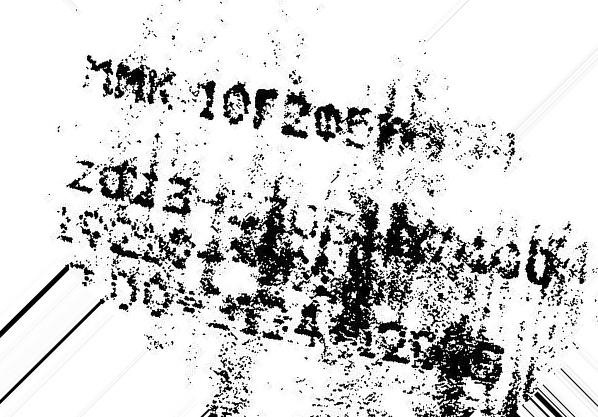

In [117]:
img = cv2.imread(example_path)
# Преобразование изображения из BGR в RGB (OpenCV использует BGR по умолчанию)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Преобразование изображения в формат, поддерживаемый IPython.display
_, img_encoded = cv2.imencode('.jpg', img_rgb)
img_bytes = img_encoded.tobytes()

display(IPImage(data=img_bytes))

In [118]:
if len(img.shape) == 2:
    print('Цветовая гамма: Grayscale')
elif len(img.shape) == 3:
    if img.shape[2] == 3:
        print('Цветовая гамма: BGR')
    elif img.shape[2] == 4:
        print('Цветовая гамма: BGRA')

Цветовая гамма: BGR


In [119]:
result = reader.readtext(example_path)

Посмотрим на результат:

In [120]:
if result:
    for item in result:
        print(item)
else:
    print('Не удалось извлечь текст с изображения')

([[82.01005050633883, 39.070353544371834], [190.78738534128422, 65.28786676075714], [175.98994949366116, 122.92964645562816], [66.2126146587158, 96.71213323924286]], '#6 ', 0.12347532078240568)
([[184.01978742397884, 62.06027813422851], [411.9049317516391, 91.77034394974504], [398.9802125760212, 158.9397218657715], [171.09506824836095, 129.22965605025496]], 'ч@г:@5;', 0.14162000656049098)
([[70.06527001946083, 131.05479516541698], [215.88971560779328, 167.6762222134575], [196.93472998053917, 231.94520483458302], [51.11028439220674, 195.3237777865425]], '203', 0.050723678091220616)


In [121]:
for (bbox, text, prob) in result:
    print(f'Text: {text}, Probability: {prob}')

Text: #6 , Probability: 0.12347532078240568
Text: ч@г:@5;, Probability: 0.14162000656049098
Text: 203, Probability: 0.050723678091220616


OCR - trocr-base-ru (HuggingFace)

In [122]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm

In [123]:
model_version = 'raxtemur/trocr-base-ru'
processor = TrOCRProcessor.from_pretrained(model_version)
model = VisionEncoderDecoderModel.from_pretrained(model_version)

In [124]:
image = cv2.imread(example_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

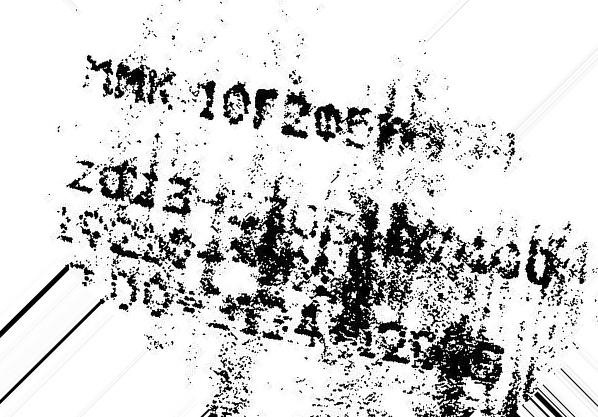

In [125]:
# Преобразование изображения в формат, поддерживаемый IPython.display
_, img_encoded = cv2.imencode('.jpg', image)
img_bytes = img_encoded.tobytes()

display(IPImage(data=img_bytes))

In [126]:
pixel_values = processor(image, return_tensors='pt').pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

статистики


OCR - trocr-base-printed

Попробуем исходник предыдущей модели от Microsoft

In [127]:
model_version = 'microsoft/trocr-base-printed'
processor = TrOCRProcessor.from_pretrained(model_version)
model = VisionEncoderDecoderModel.from_pretrained(model_version)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [128]:
pixel_values = processor(image, return_tensors='pt').pixel_values
generated_ids = model.generate(pixel_values, max_new_tokens=50)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

***


OCR - EasyOCR (ru)

Предсказание на одном фото

Используем модель as it is на одном фото

In [129]:
reader = easyocr.Reader(['ru', 'en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Попробуем на одном фото:

Загрузка изображения в ч/б виде:

In [130]:
# Загрузка изображения
img = cv2.imread(example_path)
# Убедимся, что изображение загружено правильно
if img is None:
    raise ValueError(f'Не удалось загрузить изображение по пути: {example_path}')

In [131]:
# Преобразование изображения из BGR в RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [132]:
# Преобразование изображения в формат, поддерживаемый IPython.display
_, img_encoded = cv2.imencode('.jpg', img_rgb)
img_bytes = img_encoded.tobytes()

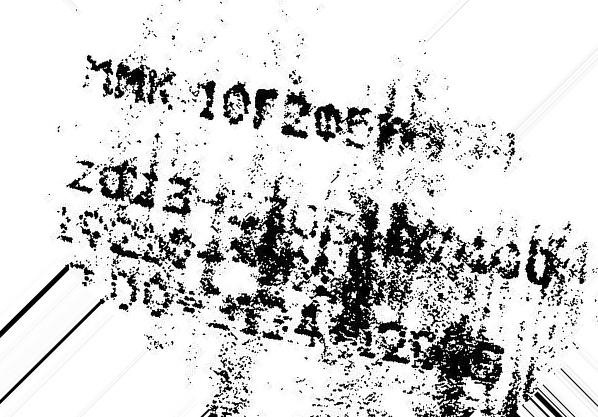

In [133]:
# Отображение изображения
display(IPImage(data=img_bytes))

In [134]:
# Распознаем текст на изображении
results = reader.readtext(img_rgb)  # Используем массив изображения, а не путь к файлу

In [135]:
# Проходим по распознанным результатам
for (bbox, text, prob) in results:
    # Получаем координаты для прямоугольника
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))
    
    # Рисуем прямоугольник вокруг текста
    img_rgb = cv2.rectangle(img_rgb, top_left, bottom_right, (0, 255, 0), 2)
    
    # Выводим текст распознанного текста и уверенность
    print(f'Распознанный текст: {text} (уверенность: {prob:.2f})')

Распознанный текст: #6  (уверенность: 0.11)
Распознанный текст: J@rEosh (уверенность: 0.20)
Распознанный текст: zal3 (уверенность: 0.18)


Изменение предобработки

In [136]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    
    if img is None:
        print(f'Ошибка загрузки изображения: {img_path}')
        return None
    
    # Увеличение контраста
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Шумоподавление
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    # Морфологические операции
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    return img

In [137]:
def preprocess_images_in_directory(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')):
            img_path = os.path.join(input_dir, filename)
            processed_img = preprocess_image(img_path)
            if processed_img is not None:
                save_path = os.path.join(output_dir, filename)
                cv2.imwrite(save_path, processed_img)

In [138]:
preprocess_images_in_directory(train_image_dir, new_train_path)

Детекция и обрезкаДетекция и обрезка

In [139]:
model = YOLO('runs/detect/train/weights/best.pt') 

In [140]:
crop_images_by_largest_object(new_train_path, new_train_path)


image 1/1 C:\Users\1\new_data\train\images\ 18986  2023-303529  192401002.jpg: 384x640 1 cat, 306.5ms
Speed: 44.9ms preprocess, 306.5ms inference, 21.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\new_data\train\images\ 18987  2023-303529  192101001.jpg: 384x640 1 cat, 142.6ms
Speed: 2.0ms preprocess, 142.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\new_data\train\images\ 18988  2023-303529  192101002.jpg: 384x640 1 cat, 155.6ms
Speed: 2.0ms preprocess, 155.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\new_data\train\images\ 18991  2023-303529  190301002.jpg: 384x640 1 cat, 149.3ms
Speed: 2.0ms preprocess, 149.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\1\new_data\train\images\ 18993  2023-303529  191201001.jpg: 384x640 1 cat, 149.6ms
Speed: 3.0ms preprocess, 149.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384

In [141]:
process_images(new_train_path, new_train_path)

Processed Труба №18986 Плавка №2023-В303529 Лист №192401002.jpg: angle 48.84
Processed Труба №18987 Плавка №2023-В303529 Лист №192101001.jpg: angle 52.15
Processed Труба №18988 Плавка №2023-В303529 Лист №192101002.jpg: angle 50.76
Processed Труба №18991 Плавка №2023-В303529 Лист №190301002.jpg: angle 50.45
Processed Труба №18993 Плавка №2023-В303529 Лист №191201001.jpg: angle 51.41
Processed Труба №18994 Плавка №2023-В303529 Лист №191601001.jpg: angle 46.54
Processed Труба №18998 Плавка №2023-В303529 Лист №191602000.jpg: angle 49.57
Processed Труба №18999 Плавка №2023-В203536 Лист №190702000.jpg: angle 49.18
Processed Труба №19000 Плавка №2023-В203536 Лист №191202000.jpg: angle 51.06
Processed Труба №19002 Плавка №2023-В203536 Лист №192101002.jpg: angle 48.04
Processed Труба №19004 Плавка №2023-В203536 Лист №192001002.jpg: angle 51.42
Processed Труба №19005 Плавка №2023-В203536 Лист №192002000.jpg: angle 45.60
Processed Труба №19006 Плавка №2023-В203536 Лист №192001001.jpg: angle 61.84

Предсказание на одном фото после изменения предобработки

In [142]:
reader = easyocr.Reader(['ru', 'en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [143]:
# Загрузка изображения
img = cv2.imread(new_example_path)
# Убедимся, что изображение загружено правильно
if img is None:
    raise ValueError(f'Не удалось загрузить изображение по пути: {example_path}')

In [144]:
# Преобразование изображения из BGR в RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [145]:
# Преобразование изображения в формат, поддерживаемый IPython.display
_, img_encoded = cv2.imencode('.jpg', img_rgb)
img_bytes = img_encoded.tobytes()

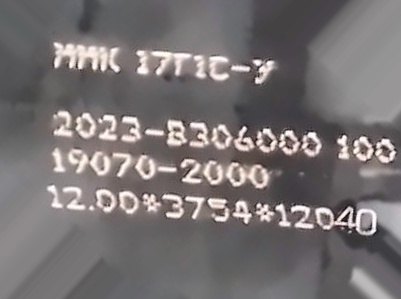

In [146]:
# Отображение изображения
display(IPImage(data=img_bytes))

In [148]:
 # Распознаем текст на изображении
results = reader.readtext(img_rgb)  # Используем массив изображения, а не путь к файлу

In [149]:
# Проходим по распознанным результатам
for (bbox, text, prob) in results:
    # Получаем координаты для прямоугольника
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))
    
    # Рисуем прямоугольник вокруг текста
    img_rgb = cv2.rectangle(img_rgb, top_left, bottom_right, (0, 255, 0), 2)
    
    # Выводим текст распознанного текста и уверенность
    print(f'Распознанный текст: {text} (уверенность: {prob:.2f})')

Распознанный текст: Hhi З771c-3 (уверенность: 0.19)
Распознанный текст: 2033-83345339 (уверенность: 0.61)
Распознанный текст: х03 (уверенность: 0.06)
Распознанный текст: 19070-2060 (уверенность: 0.40)
Распознанный текст: 12.00*3754*12040 (уверенность: 0.59)


In [152]:
! pip freeze > requirements.txt